In [1]:
from google.colab import drive
drive.mount("drive")

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/cv2020/project/Anomaly_detection/

/content/drive/MyDrive/cv2020/project/Anomaly_detection


In [ ]:
!tar -xvf "UCSD_Anomaly_Dataset.tar.gz" -C '/content/'

In [4]:
import cv2
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from dataset import*
from autoencoder import*

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_path='/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train'
train_videos=glob.glob(train_path+"/*")

spatial,temporal=get_path(train_path)

In [6]:
x_train,x_val= train_test_split(spatial,test_size=0.30, random_state=42)
train_spatial=MyDataset(x_train)
val_spatial=MyDataset(x_val)

In [7]:
encoder_spatial=AutoEncoder().to(device)
fit(encoder_spatial,train_spatial,val_spatial,6,lr=0.001)

  1%|▏         | 1/75 [00:00<00:09,  7.78it/s]

epoch: 0  train_loss: 0.0210  val_loss: 0.0065


  1%|▏         | 1/75 [00:00<00:09,  7.49it/s]

epoch: 1  train_loss: 0.0053  val_loss: 0.0048


  1%|▏         | 1/75 [00:00<00:09,  7.64it/s]

epoch: 2  train_loss: 0.0045  val_loss: 0.0042


  1%|▏         | 1/75 [00:00<00:09,  7.48it/s]

epoch: 3  train_loss: 0.0039  val_loss: 0.0039


  1%|▏         | 1/75 [00:00<00:09,  7.88it/s]

epoch: 4  train_loss: 0.0035  val_loss: 0.0034


100%|██████████| 32/32 [00:02<00:00, 13.34it/s]

epoch: 5  train_loss: 0.0033  val_loss: 0.0032


Original image


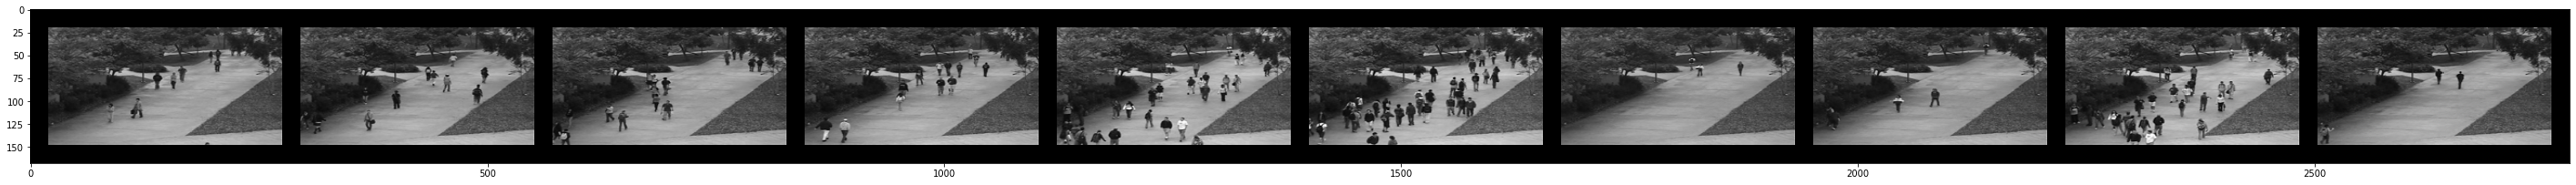

In [8]:
print("Original image")
x_test,y_test = next(iter(DataLoader(val_spatial,batch_size=10,shuffle=True)))
grid = torchvision.utils.make_grid(x_test,nrow=10, padding=20)
show(grid)


Reconstructed image


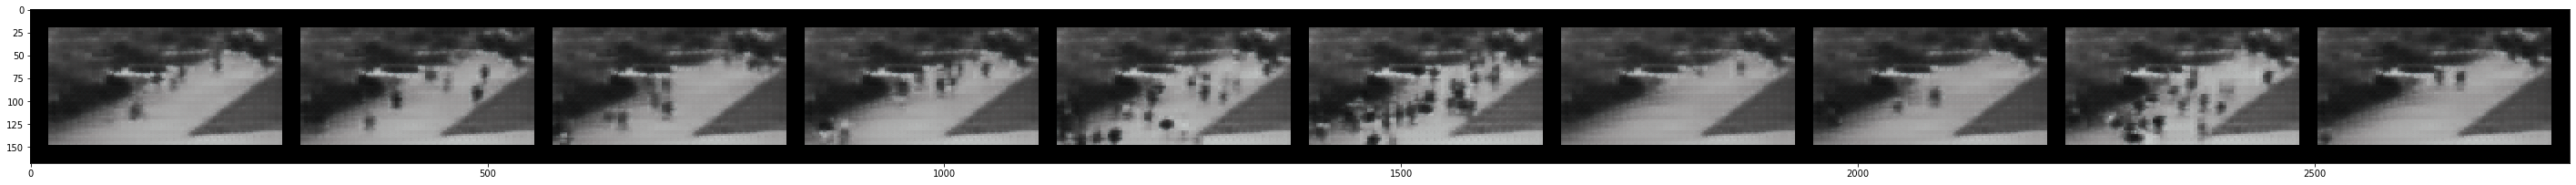

In [9]:
print("Reconstructed image")
with torch.no_grad():
  x_test_pred=encoder_spatial(x_test.to(device)).cpu()
  grid = torchvision.utils.make_grid(x_test_pred,nrow=10, padding=20)
  show(grid)


In [10]:

mse=lambda pred,target:((pred.reshape(pred.shape[0],-1)-target.reshape(target.shape[0],-1))**2).mean(dim=-1)**.5
def reconstruction_loss(model,train_data):
  loss_sample_wise=[]
  with torch.no_grad():
    for input,target in tqdm(DataLoader(train_data,batch_size=64)):
      input,target= input.to(device),target.to(device)
      pred = model(input)
      loss=mse(pred,target)
      loss=loss.cpu().numpy().tolist()
      loss_sample_wise.extend(loss)

  return loss_sample_wise

def get_cluster(loss_sample_wise,n_clusters):

  X=np.array(loss_sample_wise).reshape(-1,1)
  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
  clusters=[[] for _ in range(n_clusters)]
  for loss,label in zip(loss_sample_wise,kmeans.labels_):
    clusters[label].append(loss)
    
  return clusters



In [11]:
loss_sample_wise=reconstruction_loss(encoder_spatial,train_spatial)
n_clusters=15
clusters=get_cluster(loss_sample_wise,n_clusters)

100%|██████████| 75/75 [00:05<00:00, 12.82it/s]


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def OneVsRestClassifier(clusters):

  classifier=[SVC(gamma='auto') for _ in range(len(clusters))]
  for i in range(len(clusters)):
    x_train,y_train=clusters[i],[1]*len(clusters[i])
    x_train=np.repeat(x_train,len(clusters)-1).tolist()
    y_train=np.repeat(y_train,len(clusters)-1).tolist()
    
    for j in range(len(clusters)):
      if j!=i: x_train.extend(clusters[j])

    y_train.extend([0]*(len(x_train)-len(y_train)))
    temp=list(zip(x_train,y_train))
    np.random.shuffle(temp)
    x_train,y_train=zip(*temp)
    
    print("Training %dth classifier "%i)
    classifier[i].fit(np.array(x_train).reshape(-1,1),y_train)
    pred=classifier[i].predict(np.array(x_train).reshape(-1,1))
    print("Accuracy : ",accuracy_score(y_train, pred))

  return classifier
classifiers=OneVsRestClassifier(clusters)

Training 0th classifier 
Accuracy :  0.6220343605126807
Training 1th classifier 
Accuracy :  0.6516564008656567
Training 2th classifier 
Accuracy :  0.9689568231957139
Training 3th classifier 
Accuracy :  0.7028604786923526
Training 4th classifier 
Accuracy :  0.6333656644034917
Training 5th classifier 
Accuracy :  0.7443127202819609
Training 6th classifier 
Accuracy :  0.540016849199663
Training 7th classifier 
Accuracy :  0.6951229151845704
Training 8th classifier 
Accuracy :  0.5734210784795207
Training 9th classifier 
Accuracy :  0.6640647586007516
Training 10th classifier 
Accuracy :  0.7152130962461191
Training 11th classifier 
Accuracy :  0.8472462764114999
Training 12th classifier 
Accuracy :  0.7894203143484874
Training 13th classifier 
Accuracy :  0.7036698644738846
Training 14th classifier 
Accuracy :  0.6045902959532917


In [13]:
def predict(model,classifiers,path,spatial=True):

  anomaly=[]
  ds=MyDataset(path,spatial)

  with torch.no_grad():
    for input,target in DataLoader(ds,batch_size=1):
      recons=model(input.to(device))
      loss=mse(recons,target.to(device)).cpu().numpy()
      output=[]
      for classifier in classifiers:
        pred=classifier.predict(loss.reshape(1,1))
        output.append(pred[0])
      anomaly.append(not any(output))

  return anomaly
test_path="/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test005"
path_spatial,path_temporal=get_frames(test_path)
anomaly=predict(encoder_spatial,classifiers,path_spatial)#train_videos[0])
print("Abnormal Event" if any(anomaly) else "Normal Event")


Normal Event
